# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [610]:
import pandas as pd
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn

In [611]:
#file provided by Udacity
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
#df_twitter_archive.head()

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [612]:
#URL provided by Udacity
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open(url.split('/')[-1],mode ='wb') as file:
    file.write(r.content)

In [613]:
df_img_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')
#df_img_prediction.head()

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [614]:
#Remove values when submitting.
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [615]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [616]:
#Data file tweet-json.txt provided by Udacity, RE: API issues
df_list = []
with open('tweet_json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    # read tweet JSON data line by line
    for line in lines:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
df_tweet_data = pd.DataFrame(df_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])
#df_tweet_data.head()

In [101]:
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


2356

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [617]:
#Visual inspection of archive data
pd.options.display.max_colwidth = 200
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [618]:
#Programatic inspection of archive data
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [619]:
#Programatic inspection of archive data
sum(df_twitter_archive.duplicated('tweet_id'))

0

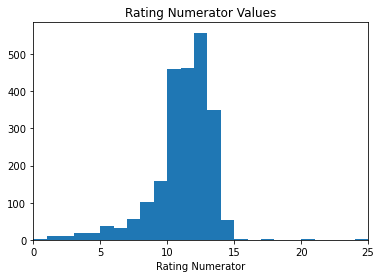

In [620]:
#df_twitter_archive['rating_numerator'].value_counts()
bins = np.arange(0, df_twitter_archive['rating_numerator'].max()+1, 1)
plt.hist(data=df_twitter_archive, x='rating_numerator', bins=bins)
plt.title('Rating Numerator Values')
plt.xlabel('Rating Numerator')
plt.xlim(0, 25);

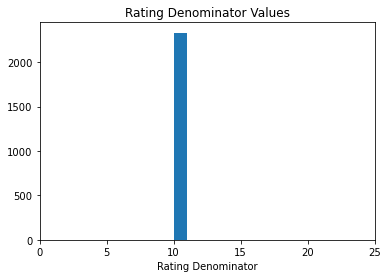

In [621]:
#df_twitter_archive['rating_denominator'].value_counts()
bins = np.arange(0, df_twitter_archive['rating_denominator'].max()+1, 1)
plt.hist(data=df_twitter_archive, x='rating_denominator', bins=bins)
plt.title('Rating Denominator Values')
plt.xlabel('Rating Denominator')
plt.xlim(0, 25);

In [622]:
df_twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [623]:
#Visual inspection of image prediction data
df_img_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [624]:
#Programatic inspection of image prediction data
df_img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [625]:
#Programatic inspection of image prediction data
sum(df_img_prediction.duplicated('tweet_id'))

0

In [626]:
#Visual inspection of tweet data
df_tweet_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [627]:
#Programatic inspection of tweet data
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [628]:
#Programatic inspection of tweet data
sum(df_tweet_data.duplicated('tweet_id'))

0

### Quality issues

Using visual and programtic inspection of the data, the following quality issues have been identified.
1. archive - rating numerator and denominator values.

2. archive - name values, many have name "a".

3. archive - data includes retweets, Retweet records should be dropped.

4. archive - Drop unnecessary columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id float, and retweeted_status_timestamp.

5. archive -  timestamp field should be datetime data type.

6. archive - expanded_urls missing values.

7. archive - rating should be a calculated value (numerator/denominator).

8. preditions - p1_dog, p2_dog, p3_dog, some values for all columns are false, not dog predictions.

### Tidiness issues

Using visual and programtic inspection of the data, the following tidiness issues have been identified.

1. archive - doggo, floofer, pupper, and puppo fields should be one categorical column.

2. predictions - p1, p2, and p3 columns can be combined into one categorical column.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [629]:
# Make copies of original pieces of data
archive_clean = df_twitter_archive.copy()
prediction_clean = df_img_prediction.copy()
tweet_clean = df_tweet_data.copy()

### Issue #1:

#### Define
The numerator and denominator values in the archive data need to be cleaned.  The majority of the numerator values are under 15 and the most common denominator value is 10.

In [630]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Code

In [631]:
#Identify bad denominator values
archive_clean.query('rating_denominator != 10.')[['rating_numerator','rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
313,960,0,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"
342,11,15,@docmisterio account started on 11/15/15
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784,9,11,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…"
902,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1068,9,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1120,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1165,4,20,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq


In [632]:
#Identify bad numerator values
archive_clean.query('rating_numerator >= 15')[['rating_numerator','rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
55,17,10,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
188,420,10,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189,666,10,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10"
285,15,10,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
290,182,10,@markhoppus 182/10
291,15,10,@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10
313,960,0,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"
340,75,10,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…"
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx


In [633]:
#Records with bad values and their corrected values
dict_n = {313:13, 433:84, 784:14, 1068:14, 1165:13, 1202:11, 1662:10, 2335:9,  340:10, 695:10, 763:11, 1712:11}
dict_d = {313:10, 433:70, 784:10, 1068:10, 1165:10, 1202:10, 1662:10, 2335:10, 340:10, 695:10, 763:10, 1712:10}

for n, numerator in dict_n.items():
    archive_clean.iloc[n, 10] = numerator

for d, denominator in dict_d.items():
    archive_clean.iloc[d, 11] = denominator

In [634]:
# drop rows that do not contain real rating values
archive_clean.drop(archive_clean.index[[342, 516, 1598]], inplace=True)

#### Test

In [635]:
archive_clean.query('rating_denominator != 10.')[['rating_numerator','rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
902,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1120,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1228,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1254,80,80,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1274,45,50,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK"
1351,60,50,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa
1433,44,40,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
1634,143,130,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3"
1635,121,110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55


In [636]:
archive_clean.query('rating_numerator >= 15')[['rating_numerator','rating_denominator', 'text']]

,rating_numerator,rating_denominator,text
55,17,10,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
188,420,10,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189,666,10,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10"
285,15,10,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI
290,182,10,@markhoppus 182/10
291,15,10,@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
902,165,150,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
979,1776,10,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1120,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv


### Issue #2:

#### Define:
Archive data set, many name values are missing or invalid. Values of "None" or lowercase words should be updated to NaN.

#### Code

In [637]:
#Replace invalid lowercase name values with None
archive_clean.name = archive_clean.name.str.replace('^[a-z]+', 'None')

/var/folders/7k/6hply5tx6zngnhj19b9jlgmr0000gn/T/ipykernel_5610/2000332559.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  archive_clean.name = archive_clean.name.str.replace('^[a-z]+', 'None')


In [638]:
#Replace 'None' values with NaN
archive_clean.loc[archive_clean['name']=='None', 'name'] = np.nan

#### Test

In [639]:
archive_clean['name'].value_counts()

Charlie       12
Lucy          11
Cooper        11
Oliver        11
Lola          10
              ..
Beya           1
Kayla          1
Edmund         1
Aqua           1
Christoper     1
Name: name, Length: 931, dtype: int64

### Issue #3:

#### Define:
3. The archive data includes retweets, all retweet records should be dropped.

#### Code

In [640]:
archive_clean = archive_clean[np.isnan(archive_clean.retweeted_status_id)]

#### Test

In [641]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2172 non-null   int64  
 1   in_reply_to_status_id       76 non-null     float64
 2   in_reply_to_user_id         76 non-null     float64
 3   timestamp                   2172 non-null   object 
 4   source                      2172 non-null   object 
 5   text                        2172 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2116 non-null   object 
 10  rating_numerator            2172 non-null   int64  
 11  rating_denominator          2172 non-null   int64  
 12  name                        1390 non-null   object 
 13  doggo                       2172 

### Issue #4:

#### Define:
4. The archive data includes unnecessary columns.  The following columns will be dropped from the dataframe: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id float, and retweeted_status_timestamp.

#### Code

In [642]:
archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [643]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2172 non-null   int64 
 1   timestamp           2172 non-null   object
 2   source              2172 non-null   object
 3   text                2172 non-null   object
 4   expanded_urls       2116 non-null   object
 5   rating_numerator    2172 non-null   int64 
 6   rating_denominator  2172 non-null   int64 
 7   name                1390 non-null   object
 8   doggo               2172 non-null   object
 9   floofer             2172 non-null   object
 10  pupper              2172 non-null   object
 11  puppo               2172 non-null   object
dtypes: int64(3), object(9)
memory usage: 220.6+ KB


### Issue #5:

#### Define:
The archive data timestamp field data type should be set to a datetime data type.

#### Code

In [644]:
#Strip the time zone +0000 from 'timestamp'
archive_clean['timestamp'] = archive_clean['timestamp'].str.slice(start=0, stop=-6)

In [645]:
#Update the 'timestamp' data type to datetime
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

#### Test

In [646]:
print(archive_clean['timestamp'].head(1))
print(archive_clean.info())

0   2017-08-01 16:23:56
Name: timestamp, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2172 non-null   int64         
 1   timestamp           2172 non-null   datetime64[ns]
 2   source              2172 non-null   object        
 3   text                2172 non-null   object        
 4   expanded_urls       2116 non-null   object        
 5   rating_numerator    2172 non-null   int64         
 6   rating_denominator  2172 non-null   int64         
 7   name                1390 non-null   object        
 8   doggo               2172 non-null   object        
 9   floofer             2172 non-null   object        
 10  pupper              2172 non-null   object        
 11  puppo               2172 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)

### Issue #6:

#### Define:
6. The archive data is missing values in the expanded_urls column.  These records should be dropped.

#### Code

In [647]:
archive_clean = archive_clean[archive_clean.expanded_urls.notnull()]

#### Test

In [648]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2116 non-null   int64         
 1   timestamp           2116 non-null   datetime64[ns]
 2   source              2116 non-null   object        
 3   text                2116 non-null   object        
 4   expanded_urls       2116 non-null   object        
 5   rating_numerator    2116 non-null   int64         
 6   rating_denominator  2116 non-null   int64         
 7   name                1390 non-null   object        
 8   doggo               2116 non-null   object        
 9   floofer             2116 non-null   object        
 10  pupper              2116 non-null   object        
 11  puppo               2116 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 214.9+ KB


### Issue #7:

#### Define:
7. The rating numerator and denominator should be combined to reflect the calculated value.

#### Code

In [649]:
# Create a new rating column, and calulate the values
archive_clean['rating'] = archive_clean['rating_numerator'] / archive_clean['rating_denominator']

#### Test

In [650]:
archive_clean['rating'].sample(5)

1943    1.2
2204    1.0
1624    0.5
2238    0.6
226     1.2
Name: rating, dtype: float64

### Issue #8:

#### Define:
The predictions data is a bit dirty, the p1_dog, p2_dog, p3_dog columns show if the prediction is for a dog or not and the p1, p2, p3 columns shown values that are not dog breeds.

#### Code

In [651]:
prediction_clean.loc[prediction_clean['p3_dog'] == True, 'dog_breed'] = prediction_clean['p3']
prediction_clean.loc[prediction_clean['p2_dog'] == True, 'dog_breed'] = prediction_clean['p2']
prediction_clean.loc[prediction_clean['p1_dog'] == True, 'dog_breed'] = prediction_clean['p1']

#### Test

In [652]:
prediction_clean.sample(5)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
1088,718971898235854848,https://pbs.twimg.com/media/CfpNGTHUIAAA8XC.jpg,1,golden_retriever,0.140394,True,Saint_Bernard,0.118769,True,Labrador_retriever,0.075492,True,golden_retriever
1836,837110210464448512,https://pbs.twimg.com/media/C54DS1kXQAEU5pS.jpg,1,Siberian_husky,0.767696,True,Eskimo_dog,0.217079,True,malamute,0.011657,True,Siberian_husky
1747,823322678127919110,https://pbs.twimg.com/media/C20HmaKWgAQ6-6X.jpg,2,cowboy_boot,0.990253,False,Chihuahua,0.001836,True,papillon,0.001274,True,Chihuahua
1890,848690551926992896,https://pbs.twimg.com/media/C8cnjHuXsAAoZQf.jpg,1,flat-coated_retriever,0.823648,True,Newfoundland,0.100571,True,groenendael,0.038310,True,flat-coated_retriever
822,693109034023534592,https://pbs.twimg.com/ext_tw_video_thumb/693108992730632192/pu/img/ncJQQZf3eroMSF12.jpg,1,cocker_spaniel,0.740013,True,Welsh_springer_spaniel,0.088739,True,golden_retriever,0.047470,True,cocker_spaniel


In [653]:
prediction_clean.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1, inplace=True)

In [654]:
prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2075 non-null   int64 
 1   jpg_url    2075 non-null   object
 2   img_num    2075 non-null   int64 
 3   dog_breed  1751 non-null   object
dtypes: int64(2), object(2)
memory usage: 65.0+ KB


### Issue #9:

#### Define:
Data tidyness issue with the archive data.  The columns doggo, floofer, pupper, and puppo should be stored within one categorical column

#### Code

In [655]:
archive_clean.loc[archive_clean['doggo'] == 'doggo', 'dog_stage'] = 'doggo'
archive_clean.loc[archive_clean['floofer'] == 'floofer', 'dog_stage'] = 'floofer'
archive_clean.loc[archive_clean['pupper'] == 'pupper', 'dog_stage'] = 'pupper'
archive_clean.loc[archive_clean['puppo'] == 'puppo', 'dog_stage'] = 'puppo'

#### Test

In [656]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating,dog_stage
1137,728046963732717569,2016-05-05 02:21:37,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Raymond. He controls fountains with his tongue. 11/10 pretty damn magical https://t.co/9aMxSbOaAZ,https://twitter.com/dog_rates/status/728046963732717569/photo/1,11,10,Raymond,None,None,None,None,1.1,NaN
1576,687460506001633280,2016-01-14 02:25:31,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kramer. He's a Picasso Tortellini. Tie couldn't be more accurate. Confident af. Runs his own business. 10/10 https://t.co/jIcVW0xxmH,https://twitter.com/dog_rates/status/687460506001633280/photo/1,10,10,Kramer,None,None,None,None,1.0,NaN
893,759446261539934208,2016-07-30 17:51:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",No no no this is all wrong. The Walmart had to have run into the dog driving the car. 10/10 someone tell him it's ok\nhttps://t.co/fRaTGcj68A,https://twitter.com/wsaznews/status/759167558763196416,10,10,NaN,None,None,None,None,1.0,NaN
507,812709060537683968,2016-12-24 17:18:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Brandi and Harley. They are practicing their caroling for later. Both 12/10 festive af https://t.co/AbBDuGZUpp,https://twitter.com/dog_rates/status/812709060537683968/photo/1,12,10,Brandi,None,None,None,None,1.2,NaN
1427,697630435728322560,2016-02-11 03:57:11,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Pls make sure ur dogs have gone through some barkour training b4 they attempt stunts like this. 8/10 https://t.co/VmF35YvtqP,https://vine.co/v/in7ZzHPKzWz,8,10,NaN,None,None,None,None,0.8,NaN


In [657]:
archive_clean.drop(['doggo','floofer','pupper', 'puppo'], axis=1, inplace=True)

In [658]:
print(archive_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2116 non-null   int64         
 1   timestamp           2116 non-null   datetime64[ns]
 2   source              2116 non-null   object        
 3   text                2116 non-null   object        
 4   expanded_urls       2116 non-null   object        
 5   rating_numerator    2116 non-null   int64         
 6   rating_denominator  2116 non-null   int64         
 7   name                1390 non-null   object        
 8   rating              2116 non-null   float64       
 9   dog_stage           338 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 181.8+ KB
None


### Issue #10:

#### Define:
Data tidyness issue with the predictions data. Values within the p1, p2, and p3 columns are not capitalized consistently. They were combined into the 'dog_breed' column, we will convert them to proper case and replace any underscores with spaces.

#### Code

In [659]:
prediction_clean['dog_breed'] = prediction_clean['dog_breed'].str.replace('_',' ')

In [660]:
prediction_clean['dog_breed'] = prediction_clean['dog_breed'].str.title()

#### Test

In [661]:
prediction_clean.sample(5)

,tweet_id,jpg_url,img_num,dog_breed
1933,859607811541651456,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,1,Golden Retriever
716,685641971164143616,https://pbs.twimg.com/media/CYPjvFqW8AAgiP2.jpg,1,Lakeland Terrier
1966,867774946302451713,https://pbs.twimg.com/media/DAr0tDZXUAEMvdu.jpg,2,Border Collie
1601,799774291445383169,https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg,1,Chow
1141,729838605770891264,https://pbs.twimg.com/ext_tw_video_thumb/729838572744912896/pu/img/RIl-XYmRxW-YLFSV.jpg,1,NaN


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [662]:
df_master = pd.concat([archive_clean, prediction_clean, tweet_clean], join='inner', axis=1)

In [663]:
df_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. Which dog breeds generated the highest volume of tweets?

2. What are the most popular dog names?

3. How has the volume of WeRateDogs tweets changed since launch?

4. Is there a relationship between favorite counts and retweets.


### Visualizations:

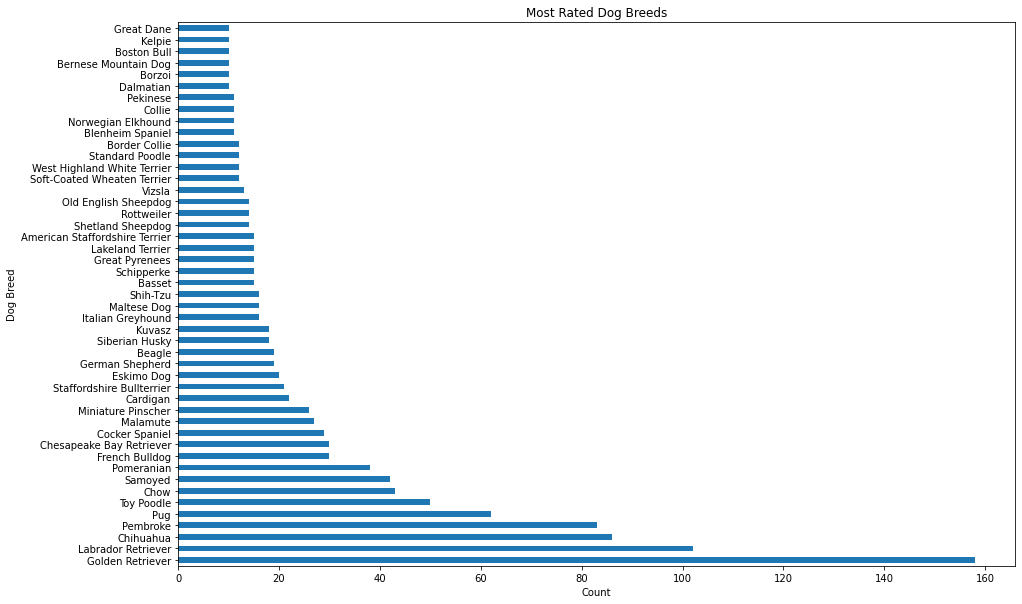

In [664]:
#Most popular dog breeds to be rated
dog_breed = df_master.groupby('dog_breed').filter(lambda x: len(x) >= 10)
dog_breed['dog_breed'].value_counts().plot(kind = 'barh', figsize = (15,10))

plt.title('Most Rated Dog Breeds')
plt.xlabel('Count')
plt.ylabel('Dog Breed');

The top five rated dog breeds were 1. Golden Retrievers, 2. Labrador Retrievers, 3. Chihuahuas, 4. Pembrokes, 5. Pugs.

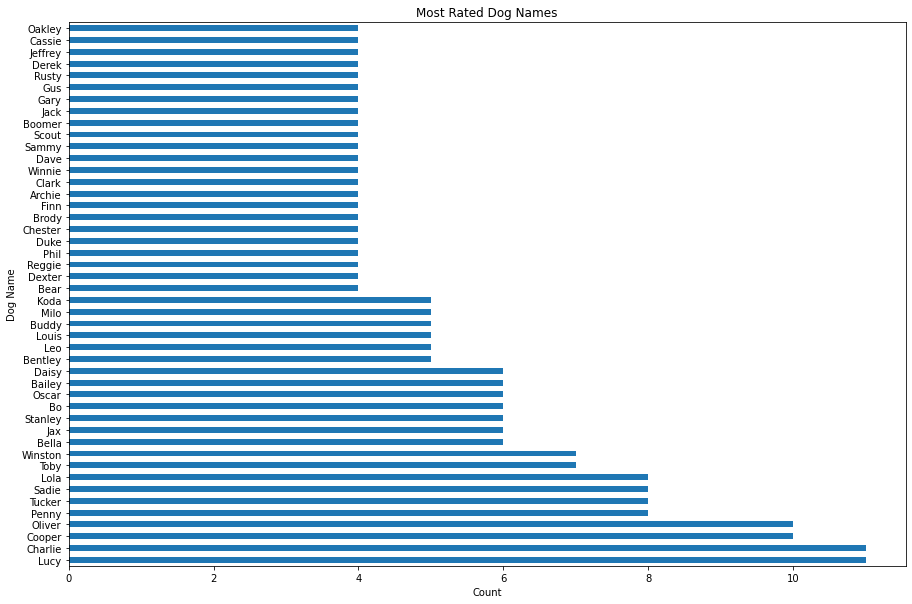

In [665]:
#Most popular dog breeds to be rated
dog_names = df_master.groupby('name').filter(lambda x: len(x)>=4)
dog_names['name'].value_counts().plot(kind = 'barh',figsize=(15,10))

plt.title('Most Rated Dog Names')
plt.xlabel('Count')
plt.ylabel('Dog Name');

The top five rated dog names were 1. Lucy, 2. Charlie, 3. Cooper, 4. Oliver, 5. Penny.

In [666]:
#Trend in volume of tweets each month over time
print(df_master['timestamp'].describe()[['first','last']])

df_master.timestamp = pd.to_datetime(df_master['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
monthly_tweets = df_master.groupby(pd.Grouper(key='timestamp', freq="M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]


first    2015-11-29 05:52:33
last     2017-08-01 16:23:56
Name: timestamp, dtype: object


/var/folders/7k/6hply5tx6zngnhj19b9jlgmr0000gn/T/ipykernel_5610/3938014174.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_master['timestamp'].describe()[['first','last']])


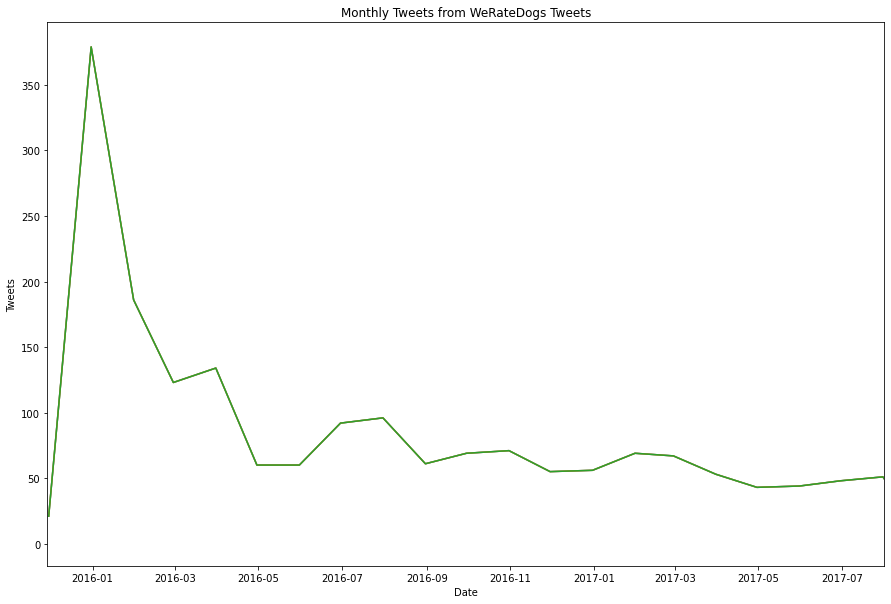

In [669]:
# Plotting time vs. tweets

plt.figure(figsize=(15, 10));
plt.xlim([datetime.date(2015, 11, 29), datetime.date(2017, 8, 1)]);

plt.xlabel('Date')
plt.ylabel('Tweets')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id);
plt.title('Monthly Tweets from WeRateDogs Tweets');

The volume of WeRateDogs tweets quickly ramped up from December 2015 to its peak in January 2016 and has tapered off through the end of the data set in mid-2017 with some short lived upticks along the way.

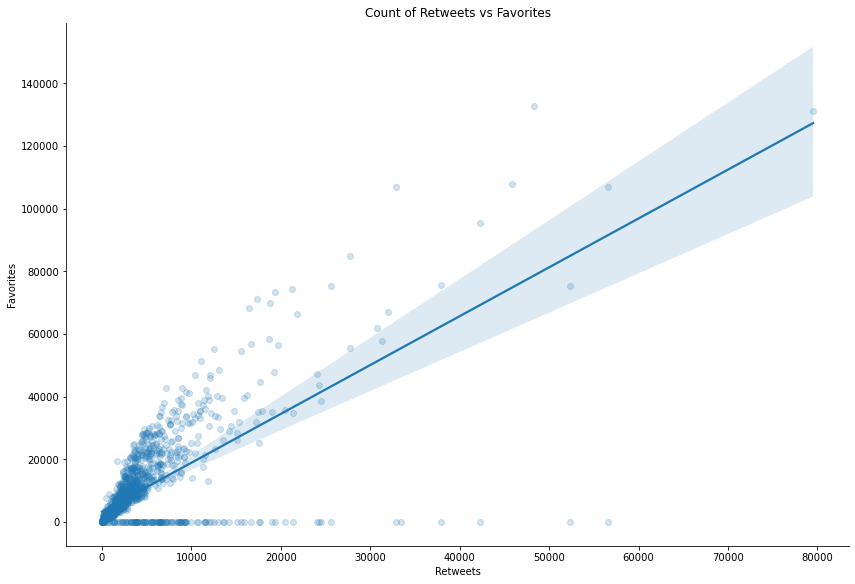

In [668]:
# Scatterplot of retweets against favorite count

seaborn.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=df_master,
           height = 8,
           aspect=1.5,
           scatter_kws={'alpha':1/5});

plt.title('Count of Retweets vs Favorites');
plt.xlabel('Retweets');
plt.ylabel('Favorites');

There is a positive correlation between favorite counts and retweets.